In [217]:
import yfinance as yf
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

##N-BEATS


In [218]:
input_size = 10
backcast_length = 10
forecast_length = 5
hidden_units = 128
num_blocks = 4
num_layers = 4
num_stacks = 4

In [219]:
class Block(nn.Module):
    def __init__(self,
                  input_size: int,
                  backcast_length: int,
                  forecast_length: int,
                  hidden_units: int,
                  hidden_layers: int):
        super(Block, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
    
        layers = []
        for _ in range(hidden_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(nn.ReLU())
            input_size = hidden_units
        layers.append(nn.Linear( hidden_units, backcast_length + forecast_length))
        self.model = nn.Sequential(*layers)
    
    def forward(self,x):
        y = self.model(x)
        y_1d = y.squeeze()
        backcast, forecast =torch.split(y_1d, [self.backcast_length, self.forecast_length], dim=0)
    
        return backcast, forecast
    
class NbeatsStack(nn.Module):
    def __init__(self, 
                 input_size: int,
                 backcast_length: int,
                 forecast_length: int,
                 hidden_units: int,
                 hidden_layers: int,
                 num_blocks: int,
                 ):
        super(NbeatsStack, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length

        self.blocks = nn.ModuleList([Block(input_size, backcast_length, forecast_length, hidden_units, hidden_layers) for _ in range(num_blocks)])
    
    def forward(self, x):
        
        forecasts = torch.tensor([0 for _ in range(self.forecast_length)])
        for block in self.blocks:
            backcast, forecast = block(x)    
            x = x - backcast.squeeze()
            forecasts =  forecasts + forecast.squeeze()
        fc = forecasts
        return x, fc
        
class Nbeat(nn.Module):
    def __init__(self, 
                 input_size: int,
                 backcast_length: int,
                 forecast_length: int,
                 hidden_units: int,
                 hidden_layers: int,
                 num_blocks: int,
                 num_stacks: int
                 ):
        super(Nbeat, self).__init__()
        self.forecast_length = forecast_length    

        self.stacks = nn.ModuleList([NbeatsStack(input_size, backcast_length, forecast_length, hidden_units, hidden_layers, num_blocks) for _ in range(num_stacks)])

    def forward(self, x):
        backcasts = []
        fcs = torch.tensor([0 for _ in range(self.forecast_length)])
        for stack in self.stacks:
            backcast, forecast = stack(x)
            fcs = fcs + forecast
            x = backcast.squeeze()

       
        return backcast, fcs


##Get Data

In [220]:
GetFacebookInformation = yf.Ticker("META")
facebook_history = GetFacebookInformation.history(period="max")
facebook_history = facebook_history['Open'].tolist()


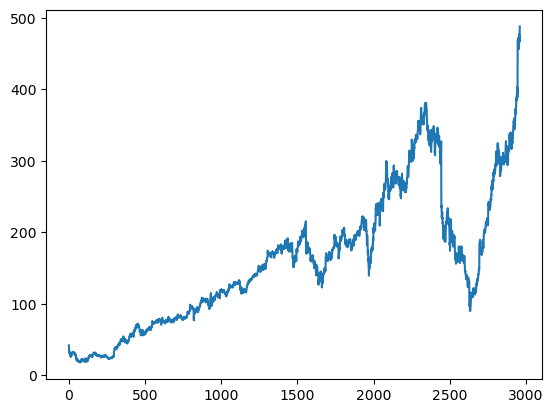

In [221]:
train_data_set = facebook_history[:2000]
eval_data_set = facebook_history[2000:2200]
test_data_set = facebook_history[2200:2800]
plt.plot(facebook_history)

In [222]:
#Pre-process data

def pre_process(dataset, backcast, forecast):
    x_l = []
    y_l = []

    for i in range(backcast, len(dataset) - forecast):

        current_dataset = []
        for ind in range(backcast + forecast + 1):
            current_dataset.append(dataset[i - backcast + ind])
        
        #Normalize by log each value and calculate the diff
        current_dataset = [math.log(elem) for elem in current_dataset]
        current_dataset = [current_dataset[i] - current_dataset[i-1] for i in range(1, len(current_dataset))]
        
        x = current_dataset[:backcast]
        y = current_dataset[backcast:]
        
        x_l.append(x)
        y_l.append(y)

    return torch.Tensor(x_l),torch.Tensor(y_l)

x_train, y_train = pre_process(train_data_set, backcast_length, forecast_length)
x_eval, y_eval = pre_process(eval_data_set, backcast_length, forecast_length)
x_test, y_test = pre_process(test_data_set, backcast_length, forecast_length)



train_data_loader = DataLoader(TensorDataset(x_train, y_train),shuffle=True)
eval_data_loader = DataLoader(TensorDataset(x_eval, y_eval),shuffle=False)
test_data_loader = DataLoader(TensorDataset(x_test, y_test),shuffle=False)

##Define model


In [240]:
model = Nbeat(input_size,
                    backcast_length,
                    forecast_length,
                    hidden_units,
                    num_layers,
                    num_blocks,
                    num_stacks)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
print(model)

Nbeat(
  (stacks): ModuleList(
    (0-3): 4 x NbeatsStack(
      (blocks): ModuleList(
        (0-3): 4 x Block(
          (model): Sequential(
            (0): Linear(in_features=10, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=128, bias=True)
            (5): ReLU()
            (6): Linear(in_features=128, out_features=128, bias=True)
            (7): ReLU()
            (8): Linear(in_features=128, out_features=15, bias=True)
          )
        )
      )
    )
  )
)


In [224]:
##Train
num_epochs = 1
train_loss = []
train_outputs = []
epoch_eval_loss = []
for epoch in range(num_epochs):
    model.train()
    ac_loss = 0
    for x, y in train_data_loader:
        optimizer.zero_grad()
        backcasts, forecasts = model(x)
        train_outputs.append(forecasts.squeeze().tolist())
        loss = criterion(forecasts.squeeze(), y.squeeze())
        ac_loss += loss
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    
    model.eval()
    eval_loss = []
    with torch.no_grad():
        for x, y in eval_data_loader:
            loss = 0
            backcasts, forecasts = model(x)
            loss = criterion(forecasts.squeeze(), y.squeeze())
            eval_loss.append(loss.item())
        epoch_eval_loss.append(np.mean(eval_loss))
    
    print(epoch)

        

0


##TRAIN SCATTER PLOT


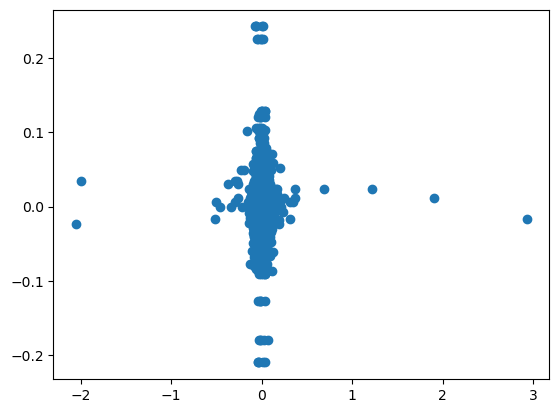

In [225]:
plt.scatter(train_outputs[:len(y_train)], y_train.tolist())


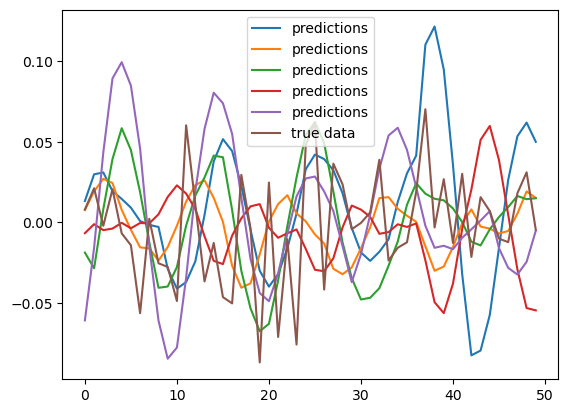

In [226]:
#Plot train data

y_t = [x[0] for x in y_train]

plt.plot(train_outputs[-50:], label="predictions")
plt.plot(y_t[-50:], label="true data")
plt.legend()


##EVALUATE TEST DATA

In [227]:
#Run test data
test_loss = 0
outputs = []
true_data = []
inputs = []

model.eval()

with torch.no_grad():
    for x,y in test_data_loader:
        
        backcasts, forecasts = model(x)
        
        outputs.append(forecasts.squeeze().tolist())
        inputs.append(x.squeeze().tolist()[-1])

        loss = criterion(forecasts.squeeze(), y.squeeze())
        

        test_loss += loss.item()
        true_data.append(y.squeeze().tolist())


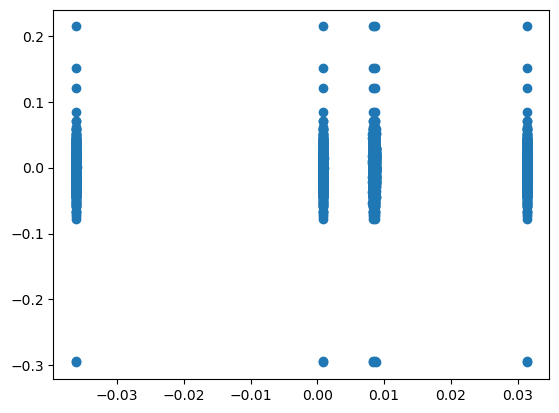

In [228]:
#Scatter plot of test data
plt.scatter(outputs, true_data)

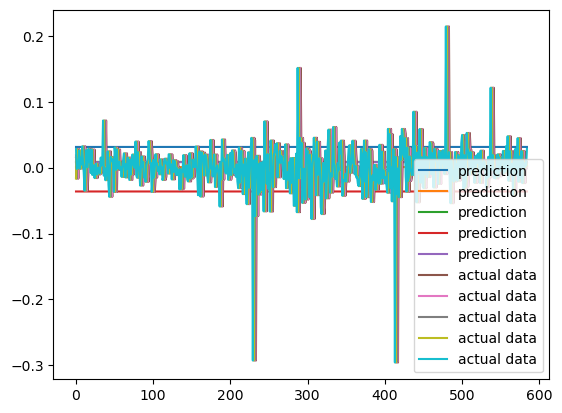

In [229]:
#Plot of test data
plt.plot(outputs, label = "prediction")
plt.plot(true_data, label="actual data")
plt.legend()

In [234]:
##ANALYZE IF PREDICTIONS
##Count number of wrong predictions and corect predictions, based on the criteria if the stock goes up or down

def check_if_correct_prediction(correct_dataset, predicted_dataset, input_dataset):

    correct_predictions = 0
    wrong_predictions = 0
    for i in range(len(correct_dataset)):
        prediction = predicted_dataset[i]
        correct = correct_dataset[i]
        input = input_dataset[i]
        if correct > input and prediction > input:
            correct_predictions += 1
        elif correct < input and prediction < input:
            correct_predictions += 1
        else:
            wrong_predictions += 1
    return correct_predictions, wrong_predictions


In [236]:
#count number of correct predictions and wrong predictions for each timestep in the forecast
for i in range(forecast_length):
    true_d = [x[i] for x in true_data]
    out = [x[i] for x in outputs]
    cor,fal = check_if_correct_prediction(true_d, out, inputs)
    print(cor, fal) 

329 256
431 154
425 160
331 254
411 174


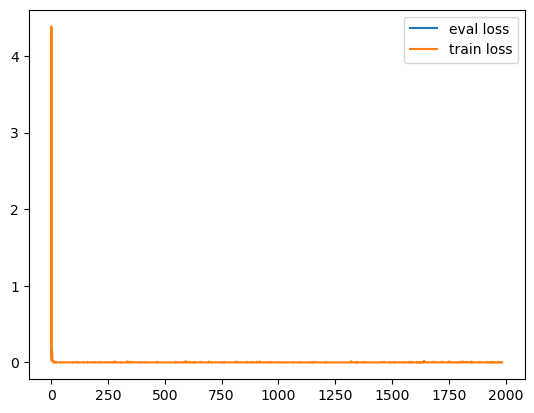

In [239]:
##Plot loss over epochs
plt.plot(epoch_eval_loss, label = "eval loss")
plt.plot([x for x in train_loss], label="train loss")

plt.legend()
